In [1]:
# !pip install yfinance
# installation of yfinance API to scrape the data from yahoo finance

In [2]:
# !pip install pmdarima
# installation of pmdarima for the Auto ARIMA function(i.e. values of p, q & d for ARIMA are calculated automaticall using statistical function)

In [3]:
# importin the various required libraries for the ARIMA analyses
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller # importing the required library(adfuller) from statsmodel.tsa.stt fro ADF test of stationary.
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima # importing auto_arima to cunduct AUTO ARIMA

In [4]:
# created a list consisting of tiker symbols used by Yfinance to scrap data from the Yahoo Finance.
ticker_symbol = ['^BSESN', '^NSE']

#created a list consisting time period values, which determine the range of data for yfinance API.
data_period = ['max']

# a dictionary is created to store the dataframe varaibles to be called/used later in different functions
data_dic = {}

In [5]:
# created a function 'data_scrap' which fetchs the data from the yfinance for the ticker: ticker_symbol and for time range : data_period 
def data_scrap(ticker_symbol, data_period):
    data = yf.Ticker(ticker_symbol)
    data_his = data.history(period = data_period)
    data_dic[f'data_{ticker_symbol}'] = data_his # stores the created dataframe in a dictionary with a custom recognizable name
    return data_his

In [6]:
# created a fuction to excat and store the names of column(column head) in a sperate varaible(list) 
# done for ease of use and universal repetation of task
def data_col_nlist(data_dic, key):
    data_col = data_dic[key].columns.tolist()
    data_dic[f'nlist{key}'] = data_col
    return data_col

In [7]:
# cleaning the index of datagframe and dropped the columns 'Dividends' &  for clean look and better analyses
def data_index(data_dic, data_key) :
    index_reset = data_dic[data_key].reset_index() # reseting the index 
    index_reset['Date'] = pd.to_datetime(index_reset['Date']).dt.tz_localize(None) # removed the timezone values and converted the 'Date' column data type to date time
    index_reset = index_reset.set_index('Date')
    index_reset = index_reset.asfreq('B').dropna()  # Set frequency explicitly
    data_dic[f'i{data_key}'] = index_reset
    return index_reset

In [8]:
# made a function to extract the column from the dataframe on which the RIMA analyses is performed
def data_colex(data_dic, data_key, col_key, col_name, ticker_symbol):
    if col_name not in data_dic[col_key]:
        raise ValueError(f"'{col_name}' is not in the column list stored under '{col_key}'") # a crosscheck to make sure that column name exists
    colex = data_dic[data_key][col_name].dropna() # extracting the column from the dataframe
    # since python convertes the single varaible time series data to series 
    # next steps converts the seris back to dataframe and renames the column
    if col_name not in ['Volume', 'Dividends', 'Stock Splits'] : # puting the coldition for renaming cloumn 
        colex = colex.to_frame(name = f'{col_name} Price')       # if condtiion maches renames the column and changes whole datatype to dataframe
    else :
        colex = colex.to_frame(name = col_name)                # if condtiion is met only changes whole datatype to dataframe

    data_dic[f'cdata_{ticker_symbol}'] = colex
    return colex

In [9]:
# created the new dictionary variable to contain the filtered and cleaned data for the purpose of ADF test
adf_data = {}

In [29]:
def q_data (data_dic , data_key, ticker_symbol) :
    df = data_dic[data_key]
    df['Return'] = df['Close Price'].pct_change()
    dataq = df['Return'].dropna()
    # df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    data_dic[f'q_{ticker_symbol}'] = dataq
    return dataq


In [11]:
# created function 'arima_date' to filter out the dataframe for the ARIMA analyses
def data_date(data_dic, data_key, ticker_symbol, start_date, end_date):
    data_ar = data_dic[data_key].loc[start_date : end_date].dropna()
    adf_data[f'adf_{ticker_symbol}'] = data_ar 
    return data_ar

In [12]:
# function to run the test of stationary (i.e. ADF test)
def s_adfuller(adf_data, data_key, test_name) : 
    adf_test = adfuller(adf_data[data_key])
    adf_data[f'{test_name}'] = adf_test 
    return adf_test

In [13]:
# printing the result of test in the tabular format 
def test_result_print(adf_data, data_key):
    result = adf_data[data_key]  # get the actual ADF result tuple

    print(f"{'Metric':<30} {'Value':>20}")
    print("-" * 52)
    print(f"{'ADF Statistic':<30} {result[0]:>20.6f}")
    print(f"{'p-value':<30} {result[1]:>20.6f}")
    print(f"{'# Lags Used':<30} {result[2]:>20}")
    print(f"{'# Observations Used':<30} {result[3]:>20}")
    print(f"{'Critical Values':<30}")
    for key, value in result[4].items():
        print(f"{'   ' + key:<30} {value:>20.6f}")

In [14]:
# to make data stationary first difference is calculated of the 'Closing Price' series
def data_f_diff(adf_data, data_key) :
    f_diff = adf_data[data_key]
    f_diff = f_diff.diff().dropna()
    adf_data[f'{data_key}_fdiff'] = f_diff
    return f_diff

In [15]:
# function for the calculation of second difference
def data_s_diff(adf_data, data_key) : 
    s_diff = adf_data[data_key]
    s_diff = s_diff.diff().diff().dropna()
    adf_data[f'{data_key}_sdiff'] = s_diff
    return s_diff

In [16]:
# creation of dictionary to keep the values of the ACF & PACF functions and ARIMA results.
arima_data = {}

In [17]:
def p_acf_pacf (adf_data, data_key, acfp_name, pacfp_name, arima_data) :
    p_acf = plot_acf(adf_data[data_key], title = f'{data_key} Autocorrelation')
    p_pacf = plot_pacf(adf_data[data_key], title = f'{data_key} Partial Autocorrelation')
    arima_data[f'{acfp_name}'] = p_acf
    arima_data[f'{pacfp_name}'] = p_pacf
    plt.show()    
    p_acf.figure.savefig(f"{acfp_name}.png")
    p_pacf.figure.savefig(f"{pacfp_name}.png")
    return plot_acf, plot_pacf

In [18]:
def v_acf_pacf (adf_data, data_key) : 
    acf_vals = acf(adf_data[data_key], nlags = 13)
    pacf_vals = pacf(adf_data[data_key], nlags = 13)
    acf_pacf_df = pd.DataFrame({
    "Lag": range(len(acf_vals)),
    "ACF": acf_vals,
    "PACF": pacf_vals
    })
    arima_data['acf_pacf_v'] = acf_pacf_df
    # print(acf_pacf_df)
    return acf_pacf_df

In [19]:
# function to run ARIMA model 
def arima_m(adf_data, data_key, p, d, q, model_name) :  # data_key & model_name to be in string
    model = ARIMA(adf_data[data_key], order = (p, d, q))  # e.g., (1,1,1)
    model_fit = model.fit()
    print(model_fit.summary())
    arima_data[f'{model_name}'] = model_fit
    return model_fit

In [20]:
def forecast(arima_data, model_name, number, forecast_name) : 
    forecast = arima_data[model_name].forecast(steps = int(number))
    arima_data[f'{forecast_name}'] = forecast
    # print(forecast)
    return forecast

In [21]:
def a_forecast(arima_data, forecast_name, adf_data, data_key):
    base_value = adf_data[data_key].iloc[-1, 0]  
    forecast_series = arima_data[forecast_name]#.cumsum().cumsum()
    n_forecast = forecast_series + base_value  
    arima_data[f'numeric_{forecast_name}'] = n_forecast
    return n_forecast

In [22]:
# ran the created function to gather the data from yfinance 
# utilized the '.head()' at teh end of function to limit the output
# as in Jupyter Notebook or IPython, the last line of a cell automatically gets "printed" if it's not assigned or explicitly suppressed.
data_scrap('^BSESN','max').head(1) 

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-07-01 00:00:00+05:30,4263.109863,4301.77002,4247.660156,4300.859863,0,0.0,0.0


In [23]:
# viewing the present names(keys) of dataframes in the data_dic
print(data_dic.keys())

dict_keys(['data_^BSESN'])


In [24]:
# ran the function data_col_nlist to grab the list of column heads in the dataframe
data_col_nlist(data_dic, 'data_^BSESN')

['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

In [25]:
# ran the function to reset the dataframe index
data_index(data_dic, 'data_^BSESN').head(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-07-01,4263.109863,4301.77002,4247.660156,4300.859863,0.0,0.0,0.0


In [26]:
print(data_dic.keys())

dict_keys(['data_^BSESN', 'nlistdata_^BSESN', 'idata_^BSESN'])


In [27]:
data_colex(data_dic, 'idata_^BSESN', 'nlistdata_^BSESN', 'Close', '^BSESN').head(1)

,Close Price
Date,
1997-07-01,4300.859863


In [30]:
q_data(data_dic , 'cdata_^BSESN', '^BSESN')

Date
1997-07-02    0.007682
1997-07-03   -0.002409
1997-07-04    0.000083
1997-07-07   -0.007486
1997-07-08    0.003481
                ...   
2025-06-11    0.001498
2025-06-12   -0.009976
2025-06-13   -0.007019
2025-06-16    0.008353
2025-06-17   -0.002602
Name: Return, Length: 6886, dtype: float64

In [31]:
print(data_dic.keys())

dict_keys(['data_^BSESN', 'nlistdata_^BSESN', 'idata_^BSESN', 'cdata_^BSESN', 'q_^BSESN'])


In [32]:
# cleaning the dataframe to the desired time lenght i.e. from Q3 of 1997 to Q1 of 2025
data_date(data_dic, 'q_^BSESN', '^BSESN', '1997-07-01', '2025-03-31').head(1)

Date
1997-07-02    0.007682
Name: Return, dtype: float64

In [33]:
# viewing the avaliable dataframes for the ADF analyses
print(adf_data.keys())

dict_keys(['adf_^BSESN'])


In [34]:
s_adfuller(adf_data, 'adf_^BSESN', 'adf_test0')
test_result_print(adf_data, 'adf_test0')

Metric                                        Value
----------------------------------------------------
ADF Statistic                            -17.230782
p-value                                    0.000000
# Lags Used                                      22
# Observations Used                            6811
Critical Values               
   1%                                     -3.431310
   5%                                     -2.861964
   10%                                    -2.566996


In [53]:
# as the p-value is less then 0.05 
# and the ADF statistics is at least one more then critical value at 5%
# this data is stationary

In [35]:
print(adf_data.keys())

dict_keys(['adf_^BSESN', 'adf_test0'])


In [40]:
print(adf_data['adf_test0'])

(-17.23078222885873, 6.1946904613924834e-30, 22, 6811, {'1%': -3.431310470746579, '5%': -2.861964449053676, '10%': -2.566995930468519}, -38480.902152884504)


In [41]:
print(adf_data.keys())

dict_keys(['adf_^BSESN', 'adf_test0'])


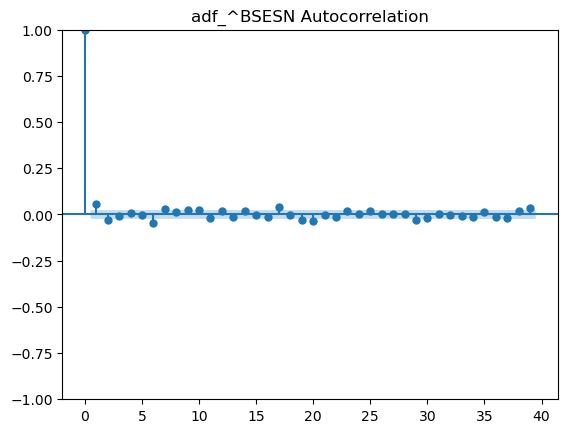

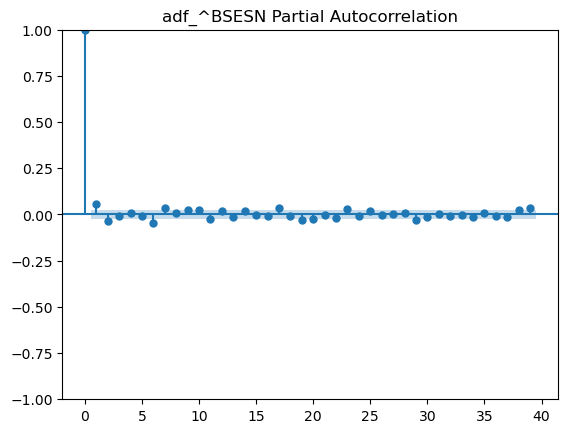

(<function statsmodels.graphics.tsaplots.plot_acf(x, ax=None, lags=None, *, alpha=0.05, use_vlines=True, adjusted=False, fft=False, missing='none', title='Autocorrelation', zero=True, auto_ylims=False, bartlett_confint=True, vlines_kwargs=None, **kwargs)>,
 <function statsmodels.graphics.tsaplots.plot_pacf(x, ax=None, lags=None, alpha=0.05, method='ywm', use_vlines=True, title='Partial Autocorrelation', zero=True, vlines_kwargs=None, **kwargs)>)

In [42]:
p_acf_pacf(adf_data, 'adf_^BSESN', 'plot_q_acf' , 'plot_q_pacf', arima_data)

In [45]:
v_acf_pacf(adf_data, 'adf_^BSESN')

,Lag,ACF,PACF
0,0,1.000000,1.000000
1,1,0.054806,0.054814
2,2,-0.031848,-0.034967
3,3,-0.009456,-0.005760
4,4,0.008218,0.008004
5,5,-0.004726,-0.006183
6,6,-0.048356,-0.047511
7,7,0.027484,0.032907
8,8,0.016070,0.009440
9,9,0.026565,0.026565


In [46]:
print(adf_data.keys())

dict_keys(['adf_^BSESN', 'adf_test0'])


In [47]:
arima_m(adf_data, 'adf_^BSESN', 2, 0, 2, 'model_fit_1')


C:\IDE_s\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\IDE_s\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\IDE_s\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                 6834
Model:                 ARIMA(2, 0, 2)   Log Likelihood               19331.996
Date:                Wed, 18 Jun 2025   AIC                         -38651.993
Time:                        00:38:54   BIC                         -38611.015
Sample:                             0   HQIC                        -38637.855
                               - 6834                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.915      0.004       0.000       0.001
ar.L1         -0.4066      0.216     -1.882      0.060      -0.830       0.017
ar.L2         -0.4136      0.105     -3.931      0.0

In [48]:
print(arima_data.keys())

dict_keys(['plot_acf', 'plot_pacf', 'acf_pacf_v', 'model_fit_1'])


In [49]:
forecast(arima_data , 'model_fit_1', 10,'forecast_1')

C:\IDE_s\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\IDE_s\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


6834    0.000230
6835    0.000392
6836    0.000700
6837    0.000507
6838    0.000458
6839    0.000558
6840    0.000538
6841    0.000505
6842    0.000526
6843    0.000531
Name: predicted_mean, dtype: float64

In [50]:
print(arima_data.keys())

dict_keys(['plot_acf', 'plot_pacf', 'acf_pacf_v', 'model_fit_1', 'forecast_1'])


In [51]:
print(data_dic.keys())

dict_keys(['data_^BSESN', 'nlistdata_^BSESN', 'idata_^BSESN', 'cdata_^BSESN', 'q_^BSESN'])


In [52]:
print(adf_data.keys())

dict_keys(['adf_^BSESN', 'adf_test0'])
